In [141]:
#import delle librerie necessarie
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns

# Caricamento e visualizzazione del dataset

In [121]:
#Caricamento e visualizzazione del dataset
dataset = pd.read_csv("../../data/sentiment140_reduced.csv", encoding="ISO-8859-1")
dataset

,target,id,date,flag,user,text
0,0,2205266671,Wed Jun 17 04:21:24 PDT 2009,NO_QUERY,SparkleAndSpunk,@SushiDeathNo1 - bÃ¶Ã¶Ã¶Ã¶ll... I'M BORED!
1,0,1557952094,Sun Apr 19 06:42:20 PDT 2009,NO_QUERY,TexasTerri,My that's early. I wish I enjoyed mornings mo...
2,0,1972627285,Sat May 30 09:34:54 PDT 2009,NO_QUERY,hippie_420_gurl,Is on her way to get a new pipe. My other broke
3,0,2323727950,Thu Jun 25 01:20:10 PDT 2009,NO_QUERY,Kali23,@DowneyJr you forgot all about me
4,0,2300962221,Tue Jun 23 14:49:12 PDT 2009,NO_QUERY,ApatheticZodiac,"@maria_lovsya boo, what a dirty trick"
...,...,...,...,...,...,...
99995,4,1969622380,Sat May 30 00:38:36 PDT 2009,NO_QUERY,LeonJay,Taking my daughter to the movies. Eating ice c...
99996,4,2014939238,Wed Jun 03 03:11:04 PDT 2009,NO_QUERY,Dynom,"@pierreJoye Yes, a while back. I found it very..."
99997,4,1993793405,Mon Jun 01 10:56:28 PDT 2009,NO_QUERY,VickiElam,"@TTVWineGal Yes, it would have not been a part..."
99998,4,1573170878,Tue Apr 21 00:00:28 PDT 2009,NO_QUERY,pixienay,wants to look at pretty things


# Rimozione colonne non necessarie e conversione del target da 4 a 1 per i tweet positivi

In [122]:
#Modifica del dataset_reduced per la rimozione delle colonne non necessarie
dataset = dataset[['text', 'target']]
dataset = dataset.copy()
dataset

,text,target
0,@SushiDeathNo1 - bÃ¶Ã¶Ã¶Ã¶ll... I'M BORED!,0
1,My that's early. I wish I enjoyed mornings mo...,0
2,Is on her way to get a new pipe. My other broke,0
3,@DowneyJr you forgot all about me,0
4,"@maria_lovsya boo, what a dirty trick",0
...,...,...
99995,Taking my daughter to the movies. Eating ice c...,4
99996,"@pierreJoye Yes, a while back. I found it very...",4
99997,"@TTVWineGal Yes, it would have not been a part...",4
99998,wants to look at pretty things,4


In [123]:
#Sostituzione dei valori della colonna 'target': 0 rimane 0 (negativo) e 4 diventa 1 (positivo)
dataset['target'] = dataset['target'].apply(lambda x: 1 if x == 4 else 0)
dataset
#Stampa distribuzione delle classi
print("Distribuzione delle classi:")
print(dataset['target'].value_counts())


Distribuzione delle classi:
target
0    50000
1    50000
Name: count, dtype: int64


# Rimozione duplicati

In [124]:
#Rimozione duplicati individuati durante la fase di data understanding (vengono rimossi i tweet che hanno lo stesso testo di altri)
# Conta il numero totale di duplicati nella colonna 'text'
numero_duplicati = dataset['text'].duplicated().sum()
print("Numero totale di duplicati nella colonna 'text':", numero_duplicati)

# Rimuovi i duplicati
dataset.drop_duplicates(subset='text', inplace=True)

# Conta il numero totale di duplicati nella colonna 'text' dopo la rimozione
numero_duplicati = dataset['text'].duplicated().sum()
print("Numero totale di duplicati nella colonna 'text' dopo la rimozione:", numero_duplicati)

Numero totale di duplicati nella colonna 'text': 296
Numero totale di duplicati nella colonna 'text' dopo la rimozione: 0


In [125]:
#Verifica dell'eliminazione dei 296 duplicati
dataset.shape

(99704, 2)

# Filtraggio tweet con lunghezza anomala

In [126]:
#Visualizza il numero di tweet con lunghezza maggiore di 140 caratteri
print("Numero di tweet con lunghezza maggiore di 140 caratteri:", dataset[dataset['text'].str.len() > 140].shape[0])

#Rimozione dei tweet con lunghezza maggiore di 140 caratteri
dataset = dataset[dataset['text'].str.len() <= 140]

dataset.shape

#Numero di tweet con lunghezza maggiore di 140 caratteri dopo la rimozione
print("Numero di tweet con lunghezza maggiore di 140 caratteri dopo la rimozione:", dataset[dataset['text'].str.len() > 140].shape[0])

Numero di tweet con lunghezza maggiore di 140 caratteri: 995
Numero di tweet con lunghezza maggiore di 140 caratteri dopo la rimozione: 0


In [127]:
#Visualizza il numero di tweet con lunghezza minore di 10 caratteri
print("Numero di tweet con lunghezza minore di 10 caratteri:", dataset[dataset['text'].str.len() < 10].shape[0])

#Stampa tutti i tweet con lunghezza minore di 10 caratteri
print("Tweet con lunghezza minore di 10 caratteri:")
print(dataset[dataset['text'].str.len() < 10]['text'].tolist())

#Rimozione dei tweet con meno di 10 caratteri e che contengono una menzione
def contains_mention(text):
    return bool(re.search(r"@\w+", text))
short_with_mention = dataset[(dataset['text'].str.len() < 10) & (dataset['text'].apply(contains_mention))]

print("Numero di tweet con meno di 10 caratteri e che contengono una menzione:", short_with_mention.shape[0])

dataset = dataset[~((dataset['text'].str.len() < 10) & (dataset['text'].apply(contains_mention)))]

# Numero di tweet con lunghezza minore di 10 caratteri dopo la rimozione
print("Numero di tweet con lunghezza minore di 10 caratteri dopo la rimozione:", dataset[dataset['text'].str.len() < 10].shape[0])

Numero di tweet con lunghezza minore di 10 caratteri: 163
Tweet con lunghezza minore di 10 caratteri:
['headache ', 'selfish ', 'I lied. ', '@gphong ', 'please? ', 'Homework ', 'ow ow ow ', 'Whatever ', 'just  tbh', 'In class ', 'homework ', 'Sunday ', 'br cold! ', 'headace ', 'Sold out ', 'Headache ', 'Revision ', 'so cold ', 'So bored ', 'Still up ', 'pusiiing ', 'Annoyed ', 'My ears ', 'So tired ', 'Tireeed ', '@sheabop ', 'HEADACHE ', 'Waiting ', '@mMmily ', 'Learning ', ' why me?', ' my life', 'Yes I am ', 'cleaning ', 'grounded ', 'i am ill ', 'raining ', 'stressed ', '@rebstew ', 'Work 9-6 ', 'learning ', 'RIP fish ', 'goodbye ', 'Confused ', 'ict....  ', 'bad day ', 'Hangover ', 'restart. ', 'nope... ', 'Over it ', 'Blackout ', 'i is sad ', 'is tired ', 'at work ', 'Hiccups ', 'Workyyyy ', ' is hurty', 'Bad day ', 'am tired ', '@Shazzib ', 'Ugh work ', 'nothing ', 'Bad head ', 'Bad day. ', 'revision ', 'thinking ', 'foooome ', 'painting ', 'LEARNiNG ', ' over it', ' fuck....', 

In [129]:
dataset.shape #Numero di tweet rimanenti

(98691, 2)

In [130]:
#Visualizzazione del dataset dopo la pulizia
dataset

,text,target
0,@SushiDeathNo1 - bÃ¶Ã¶Ã¶Ã¶ll... I'M BORED!,0
1,My that's early. I wish I enjoyed mornings mo...,0
2,Is on her way to get a new pipe. My other broke,0
3,@DowneyJr you forgot all about me,0
4,"@maria_lovsya boo, what a dirty trick",0
...,...,...
99995,Taking my daughter to the movies. Eating ice c...,1
99996,"@pierreJoye Yes, a while back. I found it very...",1
99997,"@TTVWineGal Yes, it would have not been a part...",1
99998,wants to look at pretty things,1


In [136]:
#Salvataggio del dataset su cui sarà fatto il training (deve essere fatta ancora la pulizia dei tweet)
dataset.to_csv("../../data/sentiment140_reduced_clean.csv", index=False)

In [137]:
#Caricamento del dataset pulito
dataset = pd.read_csv("../../data/sentiment140_reduced_clean.csv")
dataset

,text,target
0,@SushiDeathNo1 - bÃ¶Ã¶Ã¶Ã¶ll... I'M BORED!,0
1,My that's early. I wish I enjoyed mornings mo...,0
2,Is on her way to get a new pipe. My other broke,0
3,@DowneyJr you forgot all about me,0
4,"@maria_lovsya boo, what a dirty trick",0
...,...,...
98686,Taking my daughter to the movies. Eating ice c...,1
98687,"@pierreJoye Yes, a while back. I found it very...",1
98688,"@TTVWineGal Yes, it would have not been a part...",1
98689,wants to look at pretty things,1



Numero di tweet per ciascuna classe:
0: 49370
1: 49321


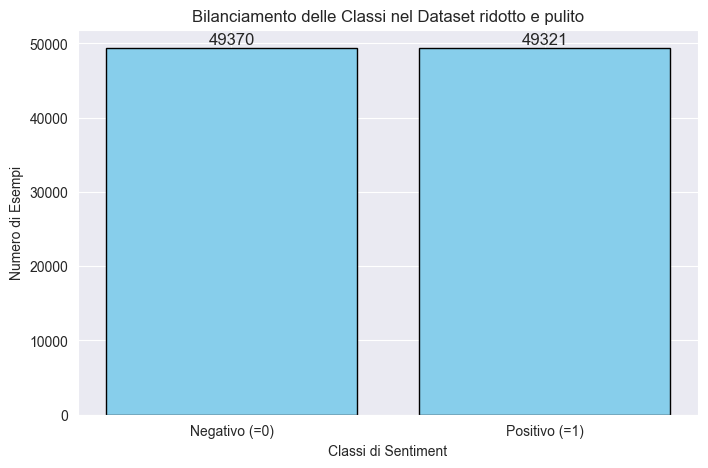

In [146]:
sentiment_counts = dataset['target'].value_counts()

# Stampa del numero di tweet per ciascuna classe
print("\nNumero di tweet per ciascuna classe:")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment}: {count}")

# Creazione del diagramma a barre con posizioni corrette
plt.figure(figsize=(8, 5))

bar_positions = range(len(sentiment_counts))
plt.bar(bar_positions, sentiment_counts.values, color='skyblue', edgecolor='black')

# Imposta le etichette personalizzate per l'asse X
plt.xticks(bar_positions, ["Negativo (=0)", "Positivo (=1)"])

plt.xlabel("Classi di Sentiment")
plt.ylabel("Numero di Esempi")
plt.title("Bilanciamento delle Classi nel Dataset ridotto e pulito")

# Aggiunta dei valori sopra le barre
for i, value in enumerate(sentiment_counts.values):
    plt.text(i, value + 500, str(value), ha='center', fontsize=12)

plt.show()

# Pulizia NLP tweet